In [1]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from lmfit import minimize, Parameters, Parameter, report_fit
from numpy import asarray
from numpy import savetxt
import os
import time
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
start = time.time() #Saves the begining time of the process

from Funciones import EstimacionVariables, DifFinitas2

In [2]:
#Variables conocidas del modelo SIR

gamma = 1./21.
fechas = pd.read_csv('Fechas/' + 'Fechas.csv')
#####################################################

depas = pd.read_csv('DEPARTAMENTOS/Departamentos.csv')
NOMBREDEPTO =  depas["Departamentos"]
#####################################################

POSITIVOSDEPTO = [] 
for n in range(len(NOMBREDEPTO)):
    rep_diarios = pd.read_csv('dA/' + NOMBREDEPTO[n] + '_ReporteDiario.csv')
    c = rep_diarios["Reporte_Diario"].values.tolist()
    POSITIVOSDEPTO.append(c)
#####################################################    

acumuladosReportados = [] 
for n in range(len(NOMBREDEPTO)):
    acumulados = pd.read_csv('ACUMULADOS/' + NOMBREDEPTO[n] + '_Acumulados_Reportados.csv')
    c = acumulados["Acumulados_Reportados"].values.tolist()
    acumuladosReportados.append(c)
    
#####################################################    

Poblacion = pd.read_csv('POBLACION/' + 'Poblacion.csv')["Poblacion"].values.tolist()

In [3]:
A, dA, S, I,R, Beta, Rt, R0 = EstimacionVariables(acumuladosReportados, POSITIVOSDEPTO, Poblacion, gamma)

In [4]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
    return result

In [42]:
#adf para diferentes intervalos
#adfuller_test(Beta[0][580:680])
adfuller_test(Beta[0][710:790])
#parece que no hay forma de hacerla estacionaria

ADF Test Statistic : -1.988893709555211
p-value : 0.29146395207126086
#Lags Used : 7
Number of Observations : 72
weak evidence against null hypothesis,indicating it is non-stationary 


(-1.988893709555211,
 0.29146395207126086,
 7,
 72,
 {'1%': -3.524624466842421,
  '5%': -2.9026070739026064,
  '10%': -2.5886785262345677},
 -632.0436031905085)

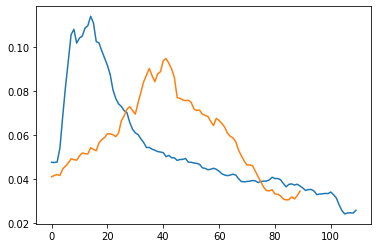

In [38]:
plt.plot(Beta[0][580:690])
plt.plot(Beta[0][720:810])

In [100]:
adfuller_test(Beta[0][:587])

ADF Test Statistic : -2.2323215982327107
p-value : 0.19472436633031864
#Lags Used : 15
Number of Observations : 571
weak evidence against null hypothesis,indicating it is non-stationary 


(-2.2323215982327107,
 0.19472436633031864,
 15,
 571,
 {'1%': -3.4418542752662518,
  '5%': -2.8666150225357914,
  '10%': -2.569472836146374},
 -5893.221470735355)

In [101]:
def adf(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
    return 

In [102]:
#si quiere de grado 2, aplique dos veces Diferencias con grado=1
#para quitar tendencia y periodicidad
def Diferencias(serie): #grado 1 implicito
    #suponga grado = 1
    #serie = [1,2,3,4,5]
    s1 = np.array(serie[:len(serie)-1]) #[1,2,3,4]
    s2 = np.array(serie[1:])#[2,3,4,5]
    serie_nueva = (s2-s1).tolist()
    return serie_nueva

In [175]:
#serie_nueva = Diferencias(Beta[0][:583])
serie_nueva = Diferencias(Beta[0][:595])


In [176]:
adfuller_test(serie_nueva)

ADF Test Statistic : -7.823088129097366
p-value : 6.590159748350945e-12
#Lags Used : 14
Number of Observations : 579
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


(-7.823088129097366,
 6.590159748350945e-12,
 14,
 579,
 {'1%': -3.441694608475642,
  '5%': -2.866544718556839,
  '10%': -2.5694353738653684},
 -5905.326046445853)

In [177]:
#Es un proceso estacionario!
inicio = 586
fin = 690
t= []
for i in range(inicio, fin+1):
    t.append(i)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


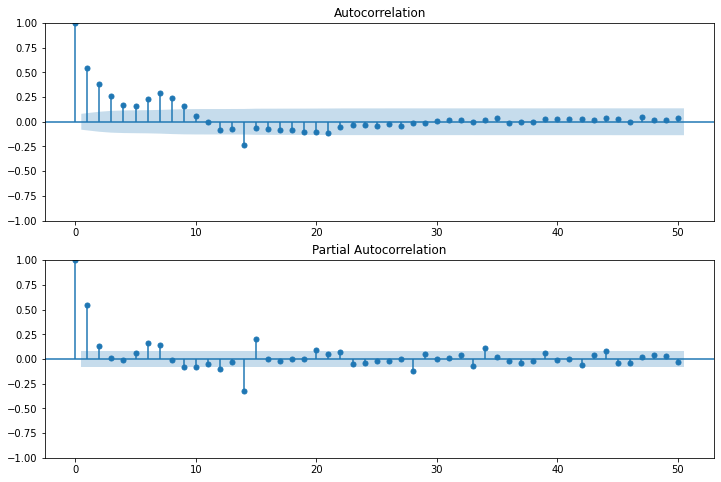

In [178]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(serie_nueva, lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(serie_nueva, lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_SerieNueva_GT_ola1.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


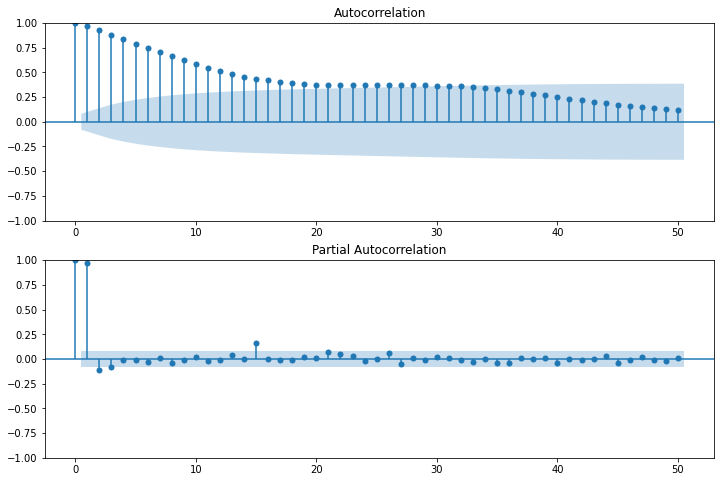

In [142]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Beta[0][:583], lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Beta[0][:583], lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_Beta_GT_ola1.pdf', bbox_inches = 'tight')


In [143]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of difference.
#q: The size of the moving average window, also called the order of moving average.

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


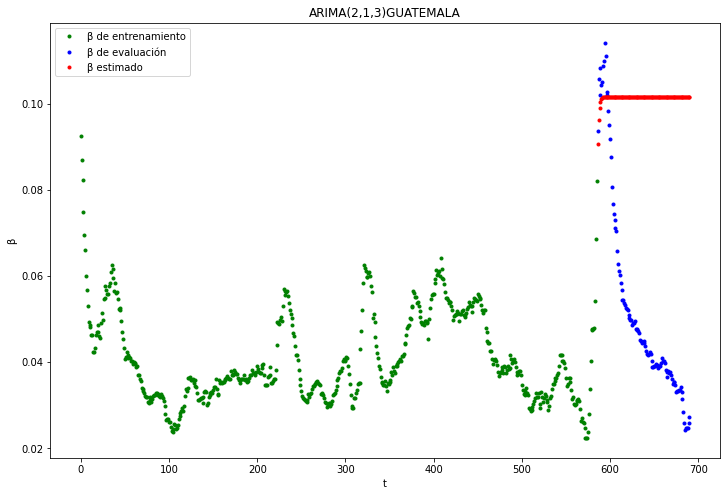

In [144]:

#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=1
q = 3
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_a.pdf', bbox_inches = 'tight')


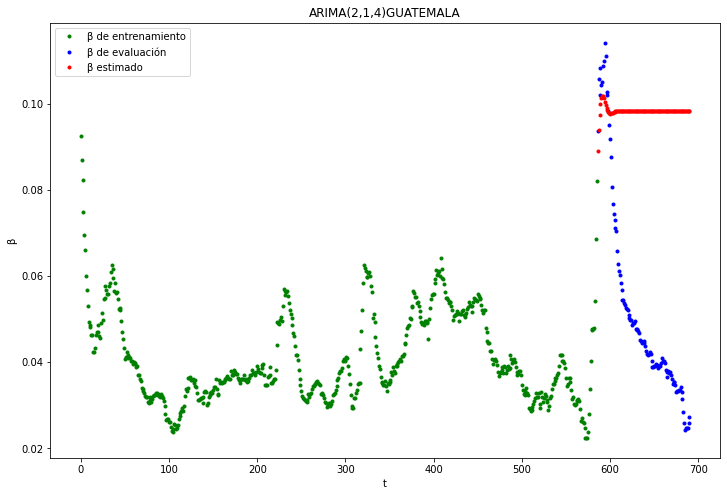

In [145]:

#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=1
q = 4
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_b.pdf', bbox_inches = 'tight')


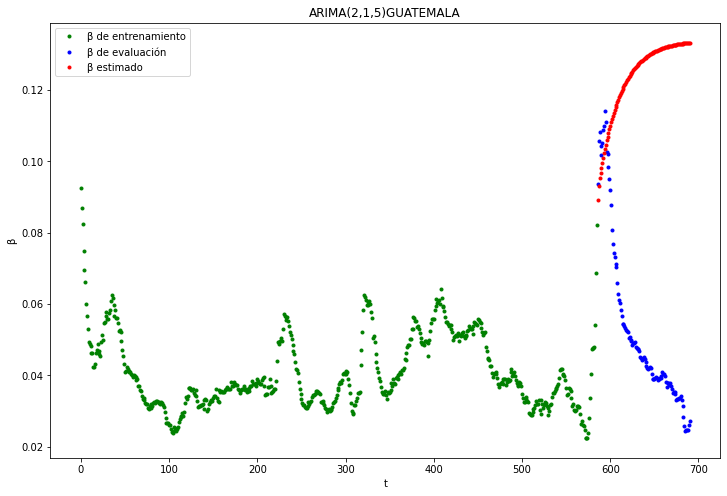

In [146]:
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=1
q = 5
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_c.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


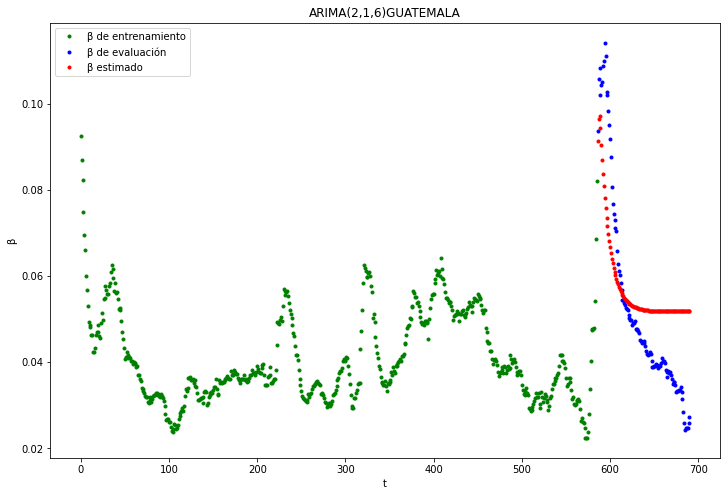

In [147]:
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=1
q = 6
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_d.pdf', bbox_inches = 'tight')


In [150]:
forecast[len(forecast)-4:len(forecast)-1] #ultimo valor predicho

array([0.05177465, 0.05177432, 0.05177402])

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


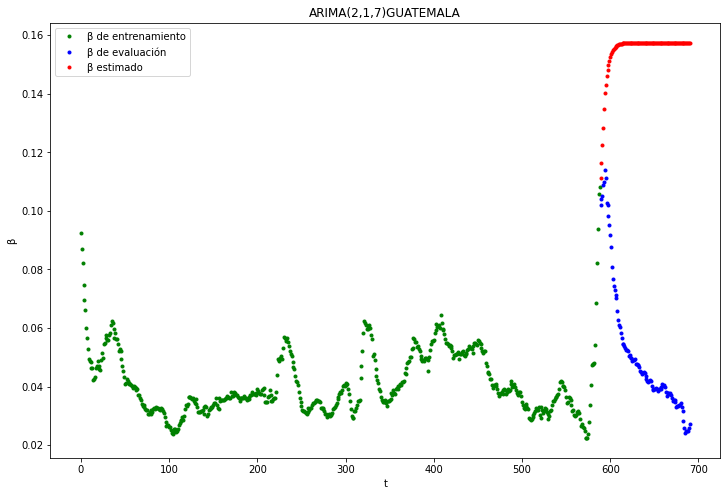

In [129]:
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=1
q = 7
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_e.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/

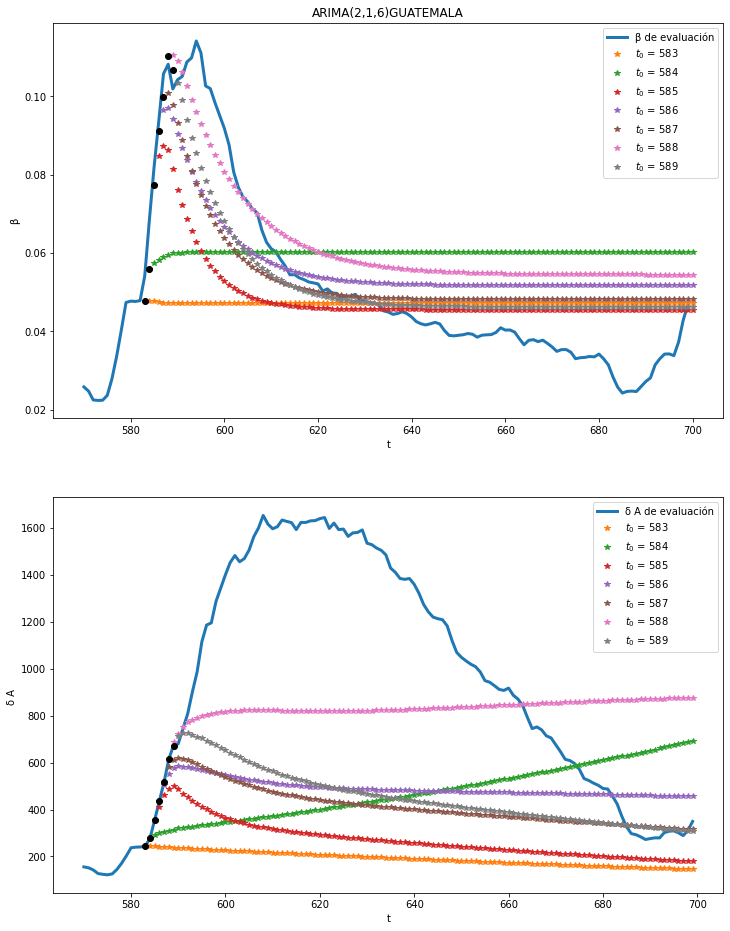

In [182]:
    #El mejor e (2,1,6)
    p=2
    d=1
    q=6
    ###################
    inicio1 = 570
    fin1 = 600 + 100
    t1 = []
    for i in range(inicio1, fin1+1):
            t1.append(i)

    fig, ax = plt.subplots(2,1,figsize=(12,16))
    ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
    ax[0].legend(loc='best')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('\u03B2')
    ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
    ax[1].legend(loc='best')
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

    for i in range(583, 590):
        inicio = i
        fin = fin1
        t= []
        for i in range(inicio, fin+1):
            t.append(i)
        model=ARIMA(Beta[0][:inicio],order=(p,d,q))
      #  d=0 porque ya es estacionario, no necesito diferencias
        model_fit=model.fit()
        model_fit.summary()

        forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
        ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
        ax[0].plot(t[0], forecast[0], 'ko')
        ax[0].legend(loc='best')
        I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
        T= fin-inicio
        dt=1
        Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

        ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
        ax[1].plot(t[0], RepDiario[0], 'ko')
        ax[1].legend(loc='best')
        
    
    plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,1,6)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])



In [183]:
np.array(Beta[0][:586]).mean()

0.04089983595848159

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/

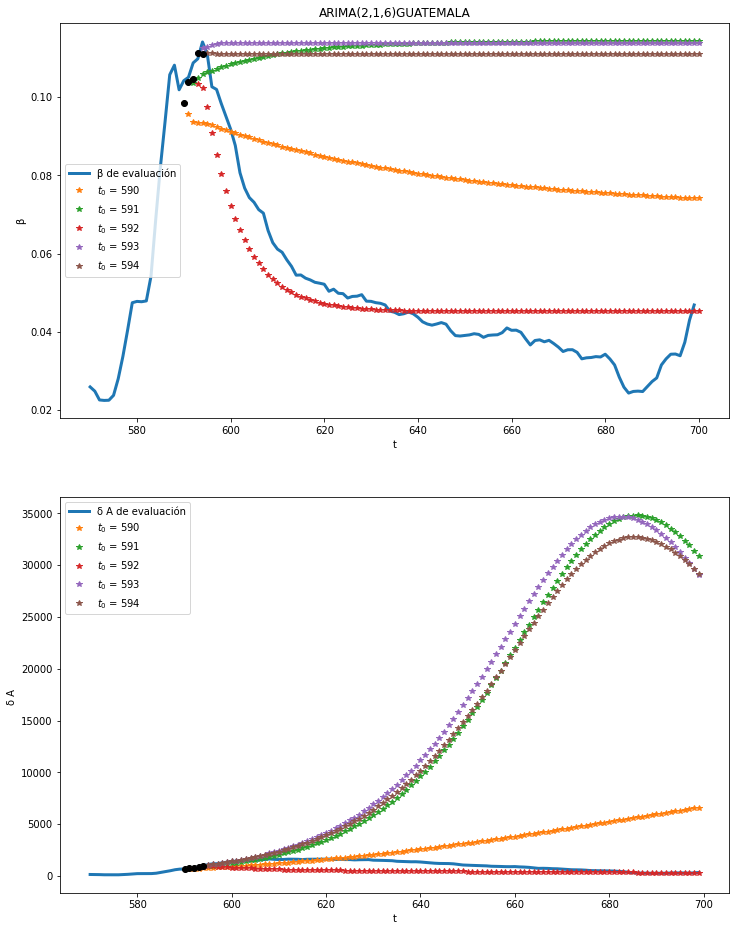

In [184]:
    #El mejor e (2,1,6)
    p=2
    d=1
    q=6
    ###################
    inicio1 = 570
    fin1 = 600 + 100
    t1 = []
    for i in range(inicio1, fin1+1):
            t1.append(i)

    fig, ax = plt.subplots(2,1,figsize=(12,16))
    ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
    ax[0].legend(loc='best')
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('\u03B2')
    ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
    ax[1].legend(loc='best')
    ax[1].set_xlabel('t')
    ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

    for i in range(590,595):
        inicio = i
        fin = fin1
        t= []
        for i in range(inicio, fin+1):
            t.append(i)
        model=ARIMA(Beta[0][:inicio],order=(p,d,q))
      #  d=0 porque ya es estacionario, no necesito diferencias
        model_fit=model.fit()
        model_fit.summary()

        forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
        ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
        ax[0].plot(t[0], forecast[0], 'ko')
        ax[0].legend(loc='best')
        I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
        T= fin-inicio
        dt=1
        Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

        ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
        ax[1].plot(t[0], RepDiario[0], 'ko')
        ax[1].legend(loc='best')
        
    
    plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,1,6)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])

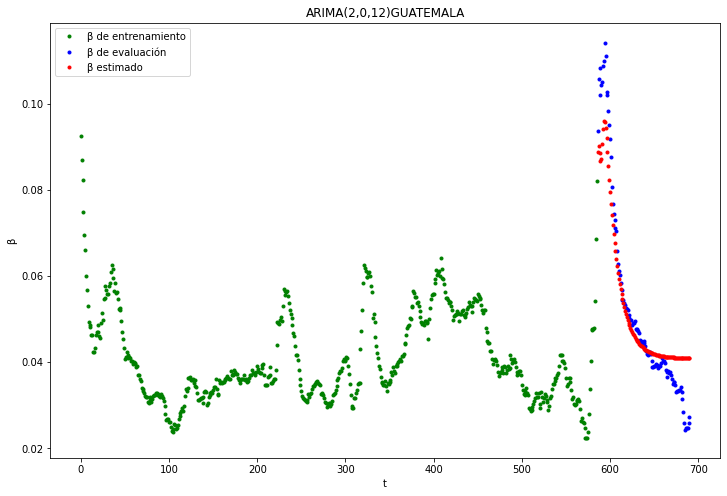

In [154]:
#suponiendo inicio=586
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=0
q = 12
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')

In [156]:
forecast[len(forecast)-4:len(forecast)-1]#ultimo valor de prediccion alcanza al promedio

array([0.04096598, 0.04096138, 0.0409571 ])

In [ ]:
np.array(Beta[0][:586]).mean()

In [133]:
#from statsmodels.graphics.tsaplots import plot_predict

#plot_predict(model_fit)
#plt.plot(Beta[0], '-')

#plt.show()

#plot_predict(model_fit, inicio, fin)
#plt.plot(Beta[0][inicio:fin+1], '-', label = "Beta Observado")
#plt.legend(loc='best')
#plt.show()

#result = model_fit.get_forecast()

# summarize forecast and confidence intervals
#print('Expected: %.3f' % result.predicted_mean)
#print('Forecast: %.3f' % test[0])
#print('Standard Error: %.4f' % result.se_mean)
#ci = result.conf_int(0.05)
#print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))

In [134]:
I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
T= fin-inicio
dt=1
Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

In [14]:
###################
#fig, ax = plt.subplots(2,1,figsize=(12,8))
#
#for i in range(583, 600, 4):
#    inicio = i
#    fin = inicio + 100
#    t= []
#    for i in range(inicio, fin+1):
#        t.append(i)
#    model=ARIMA(Beta[0][:inicio],order=(2,0,12)) #d=0 porque ya es estacionario, no necesito diferencias
#    model_fit=model.fit()
#    model_fit.summary()
    
#    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
#    ax[0].plot(t, forecast, '-')
#    ax[0].plot(Beta[0][:fin])
    
    
#    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
#    T= fin-inicio
#    dt=1
#    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

#    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1] , label = NOMBREDEPTO[0])
#    ax[1].plot(t[:len(t)-1],dA[0][inicio:fin], label = NOMBREDEPTO[0])
#    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1] , label = NOMBREDEPTO[0])
#    ax[1].plot(dA[0][:fin], label = NOMBREDEPTO[0])



/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

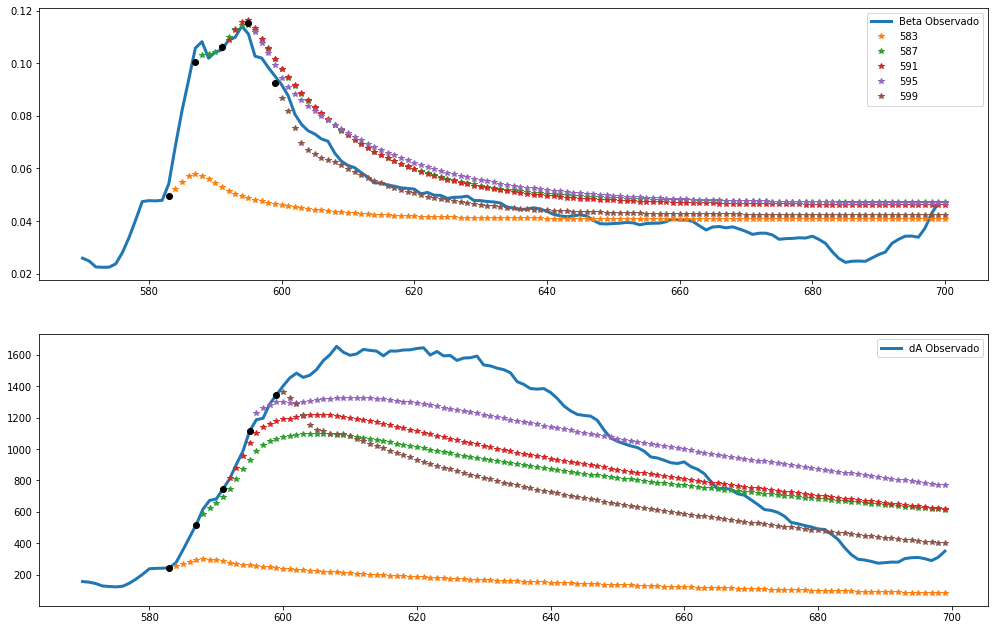

In [19]:
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
        t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(17,11))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = 'Beta Observado')
ax[0].legend()
ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = 'dA Observado')
ax[1].legend()
#ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
#ax[2].legend()
#ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
#ax[3].legend()

for i in range(583, 600, 4):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(2,0,12))
  #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()
    
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label = str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend()
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label=str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend()

#    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
#    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])



/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

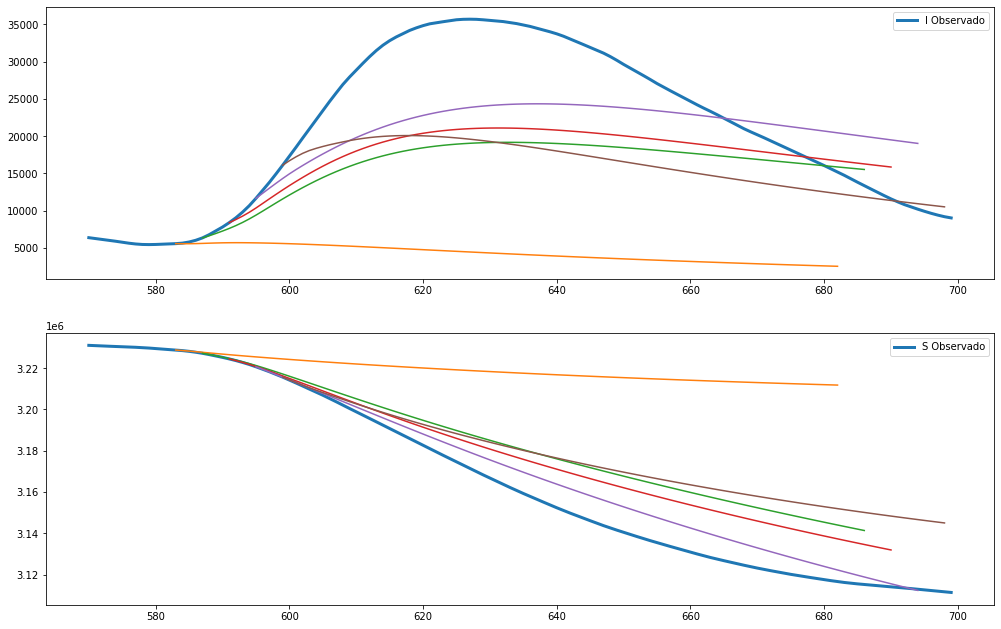

In [28]:
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
        t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(17,11))
#ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = 'Beta Observado')
#ax[0].legend()
#ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = 'dA Observado')
#ax[1].legend()
ax[0].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
ax[0].legend()
ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
ax[1].legend()

for i in range(583, 600, 4):
    inicio = i
    fin = inicio + 100
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(2,0,12))
  #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()
    
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    #ax[0].plot(t, forecast, '-')    
    
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

#    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1])
    ax[0].plot(t[:len(t)-1],Infectados[:len(t)-1])
    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

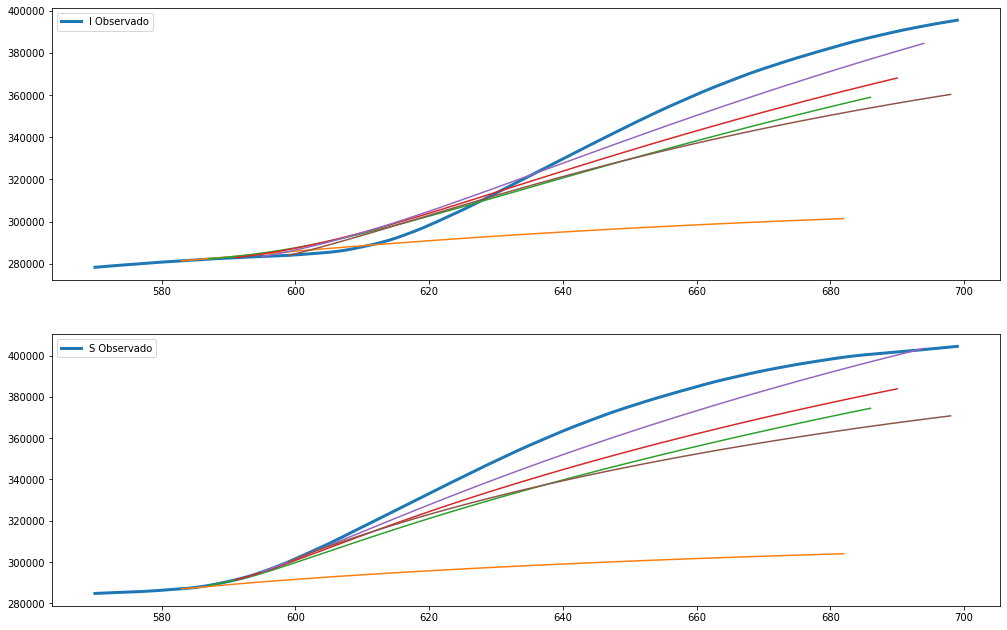

In [29]:
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
        t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(17,11))
#ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = 'Beta Observado')
#ax[0].legend()
#ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = 'dA Observado')
#ax[1].legend()
ax[0].plot(t1[:len(t1)-1], R[0][inicio1:fin1], linewidth=3, label = 'I Observado')
ax[0].legend()
ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'S Observado')
ax[1].legend()

for i in range(583, 600, 4):
    inicio = i
    fin = inicio + 100
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(2,0,12))
  #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()
    
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
#    ax[0].plot(t, forecast, '-')    
    
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t[:len(t)-1],Removidos[:len(t)-1])
    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1])
#    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

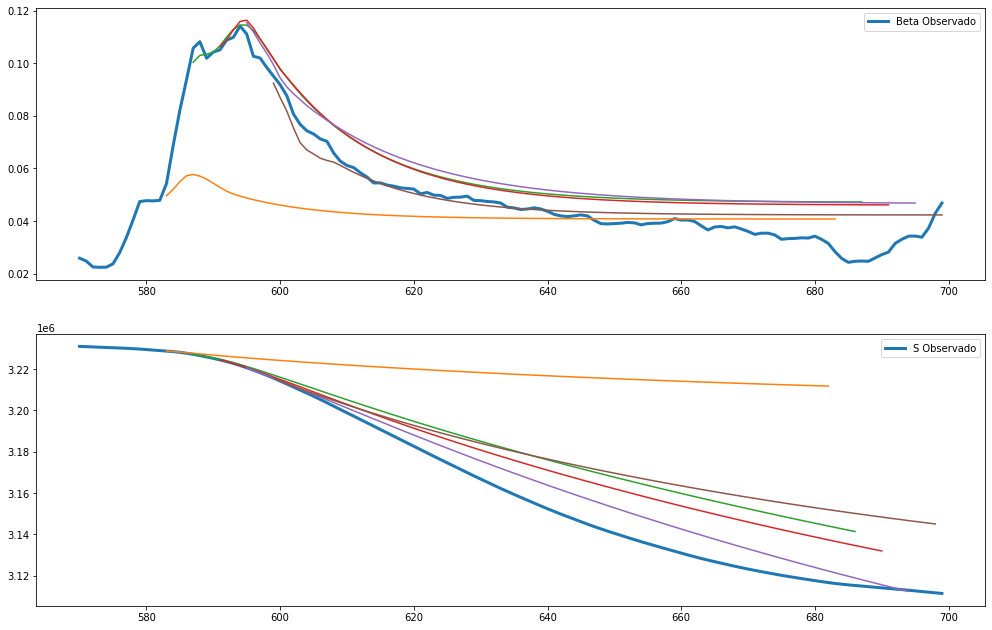

In [30]:
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
        t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(17,11))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = 'Beta Observado')
ax[0].legend()
#ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = 'dA Observado')
#ax[1].legend()
#ax[1].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
#ax[1].legend()
ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
ax[1].legend()

for i in range(583, 600, 4):
    inicio = i
    fin = inicio + 100
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(2,0,12))
  #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()
    
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '-')    
    
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

#    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1])
#    ax[1].plot(t[:len(t)-1],Infectados[:len(t)-1])
    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1])


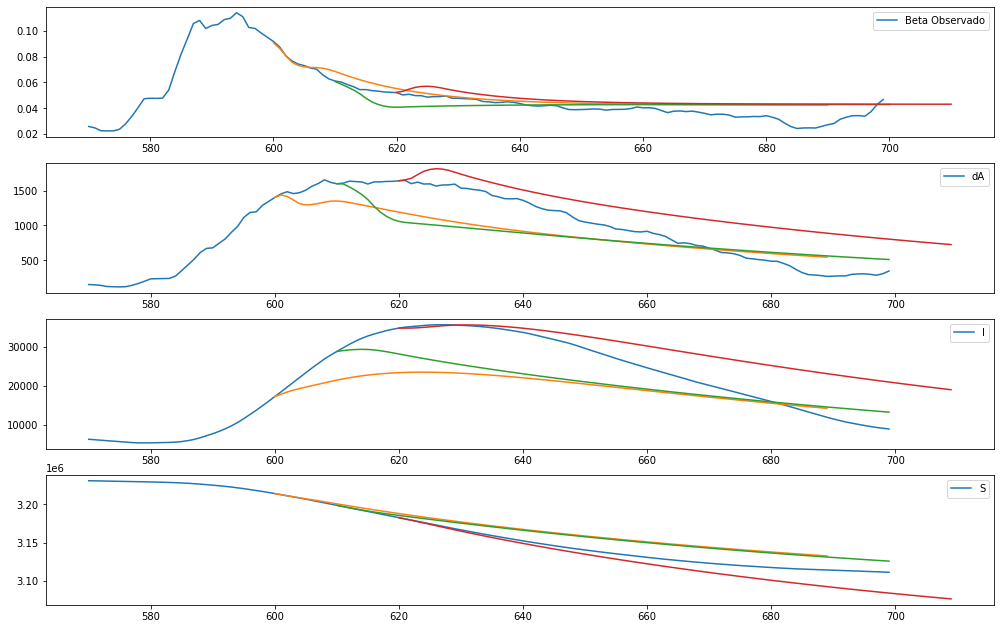

In [31]:
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
        t1.append(i)

fig, ax = plt.subplots(4,1,figsize=(17,11))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], label = 'Beta Observado')
ax[0].legend()
ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], label = 'dA')
ax[1].legend()
ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], label = 'I')
ax[2].legend()
ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], label = 'S')
ax[3].legend()

for i in range(600, 621, 10):
    inicio = i
    fin = inicio + 90
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(2,0,12))
  #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()
    
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '-')    
    
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

#    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1] , label = NOMBREDEPTO[0])
#    ax[1].plot(t[:len(t)-1],dA[0][inicio:fin], label = NOMBREDEPTO[0])
    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1])
    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])



In [32]:
inicio = 760
fin = 900
t1= []
for i in range(inicio, fin+1):
    t1.append(i)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


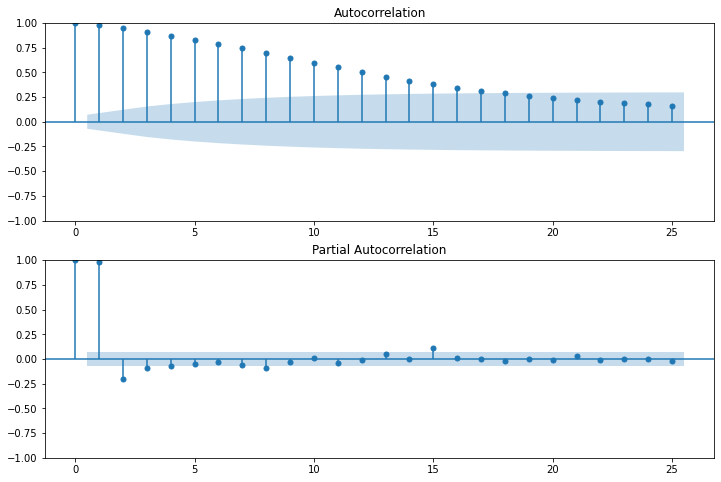

In [33]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Beta[0][:inicio], lags = 25,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Beta[0][:inicio], lags = 25,ax=ax2)


In [47]:
model=ARIMA(Beta[0][:inicio],order=(4,0,15)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  760
Model:                ARIMA(4, 0, 15)   Log Likelihood                3923.059
Date:                Sun, 22 Jan 2023   AIC                          -7804.118
Time:                        22:51:43   BIC                          -7706.819
Sample:                             0   HQIC                         -7766.650
                                - 760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0436      0.004     11.260      0.000       0.036       0.051
ar.L1          1.5221      0.419      3.631      0.000       0.700       2.344
ar.L2         -0.4989      0.572     -0.873      0.383      -1.619       0.622
ar.L3          0.0180      0.224      0.081      0.936      -0.421       0.457
ar.L4         -0.0643      0.208     -0.310      0.757      -0.471       0.342
ma.L1         -0.0770      0.422     -0.182      0.855      -0.904       0.750
ma.L2         -0.0614      0.293     -0.210      0.834      -0.635       0.512
ma.L3         -0.0052      0.277     -0.019      0.985      -0.547       0.537
ma.L4         -0.0191      0.141     -0.135      0.893      -0.296       0.258
ma.L5         -0.0650      0.109     -0.599      0.549      -0.278       0.148
ma.L6          0.2252      0.087      2.581      0.010       0.054       0.396
ma.L7          0.4285      0.090      4.780      0.000       0.253       0.604
ma.L8          0.1767      0.231      0.763      0.445      -0.277       0.630
ma.L9         -0.0098      0.227     -0.043      0.966      -0.455       0.436
ma.L10         0.0369      0.215      0.172      0.863      -0.384       0.458
ma.L11        -0.0136      0.148     -0.092      0.927      -0.303       0.276
ma.L12        -0.1129      0.115     -0.978      0.328      -0.339       0.113
ma.L13         0.1971      0.116      1.698      0.090      -0.030       0.425
ma.L14        -0.2882      0.084     -3.447      0.001      -0.452      -0.124
ma.L15         0.1513      0.112      1.353      0.176      -0.068       0.370
sigma2      1.893e-06   6.86e-08     27.613      0.000    1.76e-06    2.03e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               899.96
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+14. Standard errors may be unstable.
"""

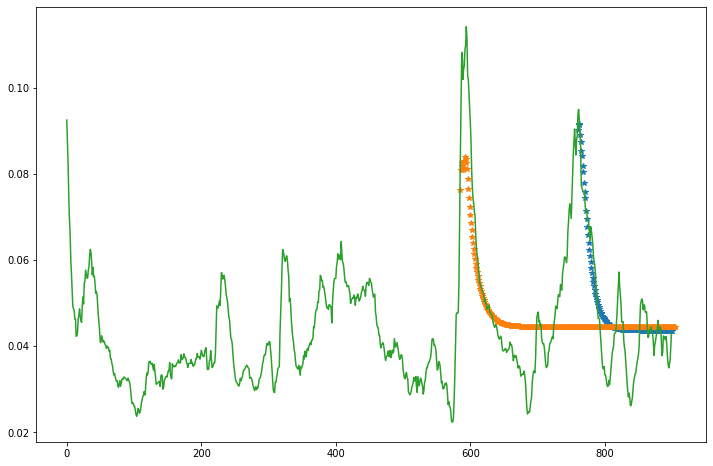

In [48]:
forecast1 = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(t1, forecast1, '*')
plt.plot(t, forecast, '*')
plt.plot(Beta[0][:fin])

In [49]:
forecast[len(forecast)-1], forecast1[len(forecast1)-1]

(0.04444552278481212, 0.04362629216658426)

In [110]:
I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
T= fin-inicio
dt=1
Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

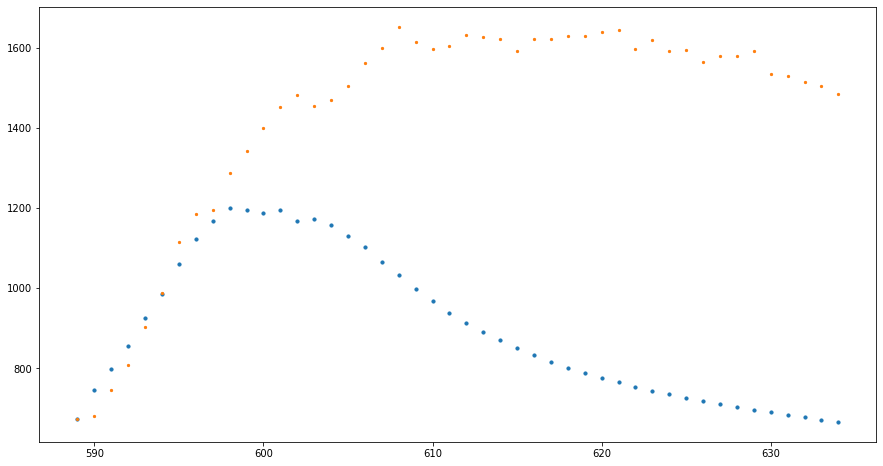

In [112]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(t[:len(t)-1],RepDiario[:len(t)-1],  s=10 , label = NOMBREDEPTO[0])
plt.scatter(t[:len(t)-1],dA[0][inicio:fin],  s=5 , label = NOMBREDEPTO[0])


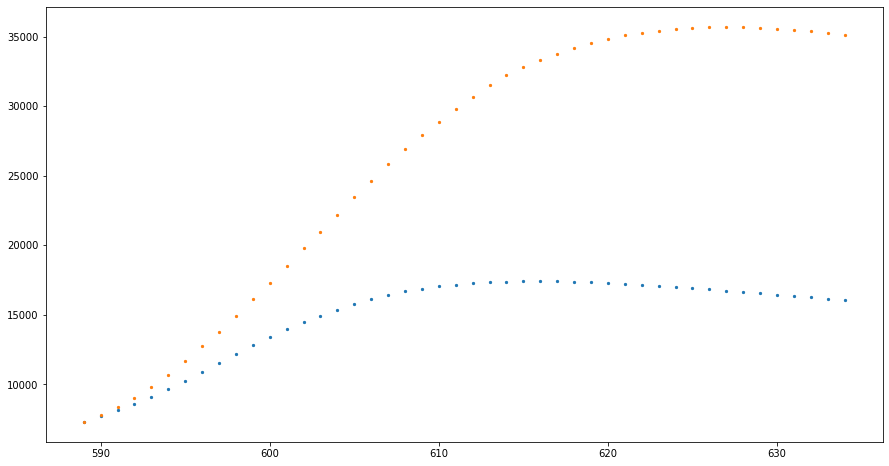

In [114]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(t[:len(t)-1],Infectados[:len(t)-1],  s=5 , label = NOMBREDEPTO[0])
plt.scatter(t[:len(t)-1],I[0][inicio:fin],  s=5 , label = NOMBREDEPTO[0])


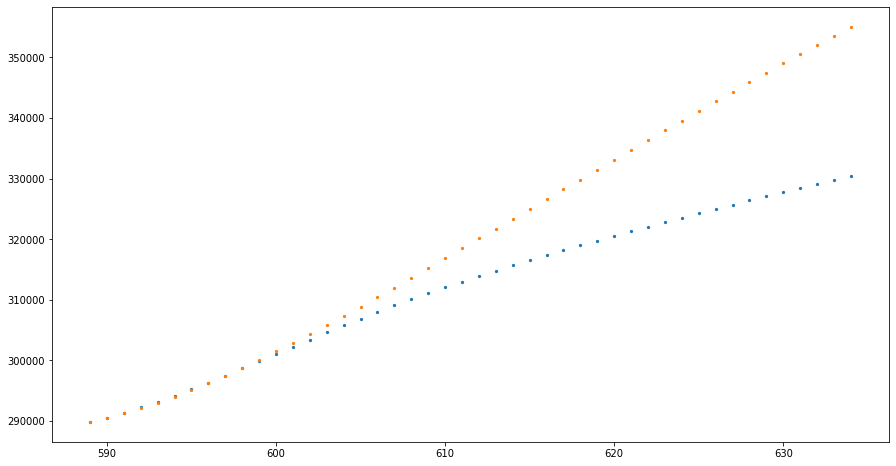

In [117]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(t[:len(t)-1],ACUMULADO[:len(t)-1],  s=5 , label = NOMBREDEPTO[0])
plt.scatter(t[:len(t)-1],A[0][inicio:fin],  s=5 , label = NOMBREDEPTO[0])

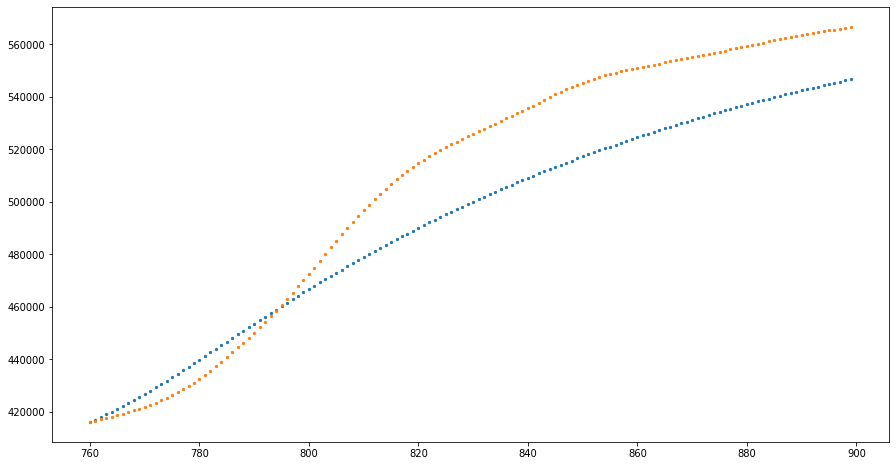

In [58]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(t1[:len(t1)-1],Removidos[:len(t1)-1],  s=5 , label = NOMBREDEPTO[0])
plt.scatter(t1[:len(t1)-1],R[0][inicio:fin],  s=5 , label = NOMBREDEPTO[0])

In [59]:
#automatizarlo para cada depto.

In [ ]:
#ejemplo
from numpy import random

def f(x,k,l):
    y = k*np.array(x)
    aleatorio = random.randint(10, size=(len(x)))
    y = y + l*aleatorio
    return y

k = 1 
x= []
for i in range(1000):
    x.append(0)
l = 1

#con x.append(0) simulara no un mov browniano sino una serie completamente aleatoria
#con x.append(i) -------------------------------------------- con tendencia lineal a la que le introduce cierto
#error, es esto MOVIMIENTO BROWNIANO CON ARRASTRE?
#En las funciones de autocorrelacion observe que justamente se ve la independencia entre valores
browniano = f(x,k,l)
plt.plot(browniano)


serie_nueva = Diferencias(browniano,1)#grado1
N = 1#grado N
for i in range(N-1):
    #porque ya lleva la de grado 1
    serie_nueva = Diferencias(serie_nueva,1)


fig, ax = plt.subplots(figsize = (15, 10))

plt.plot(serie_nueva[0:200])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(browniano, lags = 15) 

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(browniano, lags = 15, method = "ols")